## Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from timeit import default_timer as timer

## my own functions
from utils import moments_estimate, format_data

import PLN

import torch
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

/home/jchiquet/anaconda3/envs/bastien/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554788289/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Read oaks data set

In [2]:
Y = read_csv('oaks_counts.csv', sep=',').to_numpy()
O = read_csv('oaks_offsets.csv', sep=',').to_numpy()
data = format_data(counts = Y, offsets = np.log(O))

# Initialization of the variational parameters
M0, S0 = moments_estimate(Y, np.log(O))

## Test various optimizer for standard PLN

In [3]:
# Instantiating PLN model with full covariance
myPLN = PLN.full_covariance(data)

### Nlopt solver with CCSAQ on profiled ELBO

In [4]:
start = timer()
# Optimization with the CCSA solver from NLopt
res_nlopt = myPLN.fit_profiled_variational_objective(M0, S0, solver = 'nlopt', ftol = 1e-16)
end = timer()
time_nlopt = end - start

Sigma_profiled = myPLN.Sigma
B_profiled = myPLN.B

### Pytorch solver with RProp and auto-grad on profiled ELBO

In [5]:
start = timer()
# Optimization with Rprop solver from Pytorch with autograd
res_torch = myPLN.fit_profiled_variational_objective(M0, S0, solver = 'torch', device = device, lr = 1, nsteps=100, ftol = 1e-3)
end = timer()
time_torch = end - start

Sigma_profiled_torch = myPLN.Sigma
B_profiled_torch = myPLN.B

### V-EM

In [6]:
start = timer()
# Optimization with the CCSA solver from NLopt
res_VEM = myPLN.fit_variational_objective(M0, S0)
end = timer()
time_vem = end - start

Sigma_VEM = myPLN.Sigma
B_VEM = myPLN.B

Step # 0, loss: [48204.61862388], delta: [1.]
Step # 1, loss: [41427.92429482], delta: [0.16357794]
Step # 2, loss: [41427.51681999], delta: [9.83584971e-06]
Step # 3, loss: [41427.51615847], delta: [1.59681304e-08]
Step # 4, loss: [41427.51615847], delta: [0.]


## Some outputs

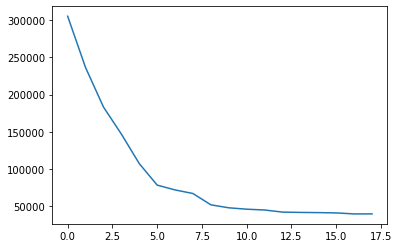

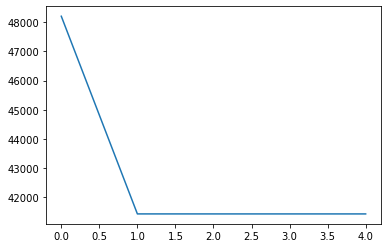

41110.78439741155
26112.19551330985
41427.51615847423
0.0870961399996304
0.058115510997595266
0.3610429309992469


In [8]:
plt.plot(res_torch['objective'][5:])
plt.show()
plt.plot(res_VEM['objective'])
plt.show()

print(res_nlopt['criterion'])
print(res_torch['criterion'])
print(res_VEM['criterion'])
print(time_nlopt)
print(time_torch)
print(time_vem)


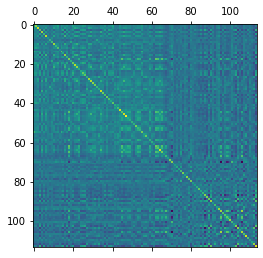

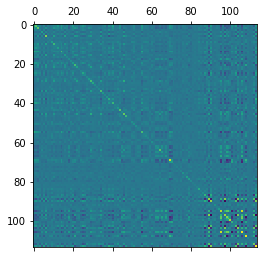

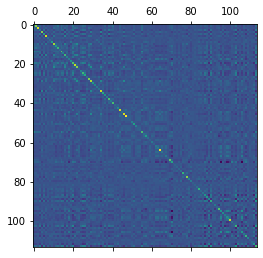

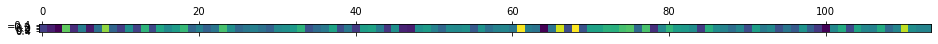

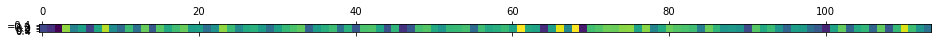

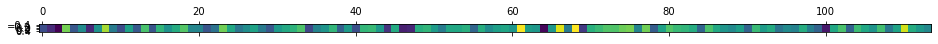

In [13]:
plt.matshow(Sigma_profiled)
plt.matshow(Sigma_profiled_torch)
plt.matshow(Sigma_VEM)
plt.matshow(B_profiled)
plt.matshow(B_profiled_torch)
plt.matshow(B_VEM)


In [ ]:
plt.matshow(Sigma_profiled_torch)